<h1><center><font size="25">Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>Diciembre, 2021 (última actualización Enero 2022)</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Skforecast: forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [Predicción (forecasting) de visitas a página web con machine learning](https://www.cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learning.html)
+ [skforecast](https://joaquinamatrodrigo.github.io/skforecast/)

## Introducción
<br>

Los [modelos basados en *gradient boosting*](https://www.cienciadedatos.net/documentos/py09_gradient_boosting_python.html) destacan dentro de la comunidad de machine learning por los buenos resultados que consiguen en multitud de casos de uso, tanto de regresión como de clasificación. Aunque su uso en el *forecasting* de series temporales ha sido limitado, en los últimos años se ha demostrado que también pueden conseguir resultados muy competitivos. Algunas de las ventajas que presenta el uso de este tipo de modelos son:

+ Facilidad para incluir variables exógenas además de las autorregresivas.

+ Permiten incorporar en el modelo comportamientos no lineales.

+ Elevada escalabilidad, lo que permite aplicarlos cuando se dispone de grandes volúmenes de datos.


A pesar de sus potenciales ventajas, a la hora de aplicar modelos de *machine learning* a problemas de forecasting aparecen una serie de complicaciones que pueden hacer que el analista sea reticente a su uso, las principales son:

+ Reestructurar los datos de forma que puedan ser utilizados como si de un problema de regresión se tratara.

+ Dependiendo de cuántas predicciones a futuro se quieran obtener (horizonte de predicción), se tienen que programar procesos iterativos en los que, cada nueva predicción, utiliza las predicciones anteriores.

+ La validación de los modelos requiere de estrategias específicas como *backtesting*, *walk-forward validation* o *time series cross-validation*. El uso de la validación cruzada tradicional no aplica en estos casos.

La librería [**skforecast**](https://joaquinamatrodrigo.github.io/skforecast/) automatiza muchos de estos procesos, facilitando el uso y validación modelos de *machine learning* en problemas de *forecasting*. A lo largo de este documento, se muestra cómo utilizar tres de las implementaciones más avanzadas de modelos *gradient boosting*: **XGBoost**, **LightGBM** y **Catboost**.

*Nota: no siempre los modelos de machine learning superan a modelos modelos propios del aprendizaje estadístico como AR, ARIMA o Exponential Smoothing. Cuál funcione mejor depende en gran medida de las características del caso de uso al que se apliquen.*

<br><br>

## Caso de uso
<br>

<img src="./images/logo-bike-sharing.jpg" style="width: 300px" align="left">

Los sistemas de bicicletas compartidas, también conocidos como sistemas de bicicletas públicas, facilitan la disponibilidad automática de bicicletas para que sean utilizadas temporalmente como medio de transporte. La mayoría de estos sistemas permiten recoger una bicicleta y devolverla en un punto diferente (estaciones o *dockers*), para que el usuario solo necesite tener la bicicleta en su posesión durante el desplazamiento. Uno de los principales retos en la gestión de estos sistemas es la necesidad de redistribuir las bicicletas para intentar que, en todas las estaciones, haya bicicletas disponibles a la vez que espacios libres para devoluciones.

Con el objetivo de mejorar la planificación y ejecución de la distribución de las bicicletas, se plantea crear un modelo capaz de predecir el número de usuarios para las siguientes 36 horas. De esta forma, a las 12h de cada día, la compañía encargada de gestionar las estaciones de alquiler, podrá conocer la demanda prevista el resto del día (12 horas) y el siguiente día (24 horas). Para simplificar el ejemplo mostrado en este documento, se asume que se está modelando una única estación.
<br><br>

## Librerías
<br>

Las librerías utilizadas en este documento son:

In [13]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
%config Completer.use_jedi = False

La versión de skforecast utiliza es: [**skforecast v0.4.2**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html).

## Datos
<br>

Los datos empleados en este documento representan el uso, a nivel horario, del sistema de alquiler de bicicletas en la ciudad de Washington D.C. durante los años 2011 y 2012. Además del número de usuarios por hora, se dispone de información sobre las condiciones meteorológicas y sobre los días festivos. Los datos originales se han obtenido del [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) y han sido limpiados previamente ([código](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/code/prepare_bike_sharing_dataset.ipynb)) aplicando las siguientes modificaciones :

+ Columnas renombradas con nombres más descriptivos.

+ Categorías de la variable meteorológica renombradas. La categoría de *heavy rain*, se ha combinado con la de *rain*.

+ Variables de temperatura, humedad y viento desnormalizadas.

+ Creada variable *date_time* y establecida como índice.

+ Imputación de valores *missing* mediante *forward fill*.


El data set resultante contiene las columnas:

- date_time: fecha y hora.

- month : mes (1 al 12).

- hour : hora (0 al 23).

- holiday : si el día es festivo o no (obtenido de from http://dchr.dc.gov/page/holiday-schedule).

- weekday : día de la semana (Lunes=0, Domingo=6).

- workingday : si es un día laboral.

- weathersit : la meteorología del día (clear, mist, rain).

- temp : temperatura registrada.

- atemp: sensación térmica.

- hum: humedad registrada.

- windspeed: velocidad del viento registrada.

- users: usuarios totales del servicio de alquiler de bicicletas.


In [14]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
datos = pd.read_csv(url)
datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('date_time')
datos = datos.asfreq('H')
datos = datos.sort_index()
datos

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0000,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,32.0,1,2,5
2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,13.0,1,3,5
2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,1.0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,119.0,12,19,0
2012-12-31 20:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,89.0,12,20,0
2012-12-31 21:00:00,0.0,1.0,clear,10.66,12.880,60.0,11.0014,90.0,12,21,0


Con el objetivo de poder entrenar los modelos, hacer búsqueda de los mejores hiperparámetros y, finalmente, evaluar su capacidad predictiva, se reparten los datos en tres conjuntos: entrenamiento, validación y test.

In [15]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2012-03-31 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Fechas validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


## Exploración gráfica

La exploración gráfica de una serie temporal es muy útil para identificar tendencias, patrones y estacionalidad, lo que resulta muy útil para orientar la selección de lags temporales que pueden ser buenos predictores.

### Representación de la serie temporal

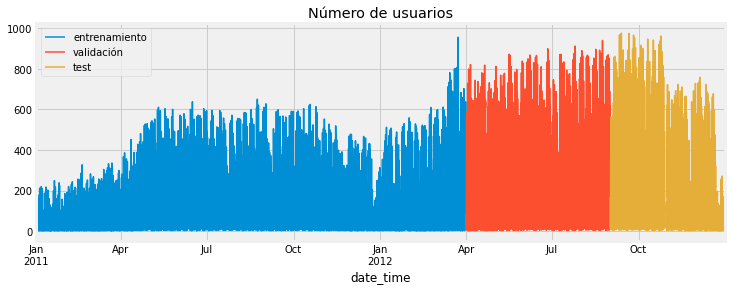

In [16]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['users'].plot(ax=ax, label='entrenamiento')
datos_val['users'].plot(ax=ax, label='validación')
datos_test['users'].plot(ax=ax, label='test')
ax.set_title('Número de usuarios')
ax.legend();

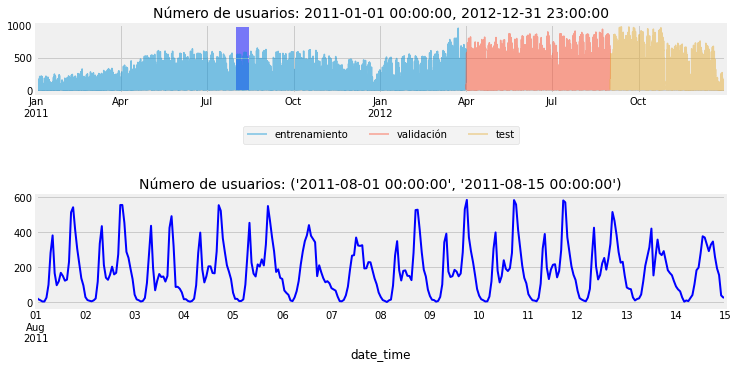

In [17]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['users'].plot(ax=main_ax, label='entrenamiento', alpha=0.5)
datos_val['users'].plot(ax=main_ax, label='validación', alpha=0.5)
datos_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['users'])
max_y = max(datos['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

datos.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Número de usuarios: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [18]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos.loc[:fin_train, 'particion'] = 'entrenamiento'
datos.loc[fin_train:fin_validacion, 'particion'] = 'validación'
datos.loc[fin_validacion:, 'particion'] = 'test'

fig = px.line(
    data_frame = datos.reset_index(),
    x      = 'date_time',
    y      = 'users',
    color  = 'particion',
    title  = 'Número de usuarios',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

datos=datos.drop(columns='particion')

### Gráficos de estacionalidad

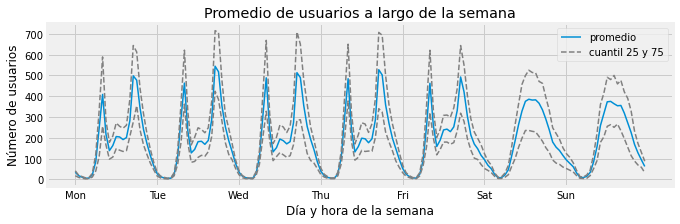

In [19]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
promedio_dia_hora = datos.groupby(["weekday", "hour"])["users"].mean()
q25_dia_hora = datos.groupby(["weekday", "hour"])["users"].quantile(0.25)
q75_dia_hora = datos.groupby(["weekday", "hour"])["users"].quantile(0.75)

promedio_dia_hora.plot(ax=ax, label='promedio')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Promedio de usuarios a largo de la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora de la semana",
    ylabel="Número de usuarios"
)

ax.legend();

Existe una clara diferencia entre los días entre semana y el fin de semana. También se observa un claro patrón intradiario, con diferente afluencia de usuarios dependiendo de la hora del día.

### Gráficos de autocorrelación

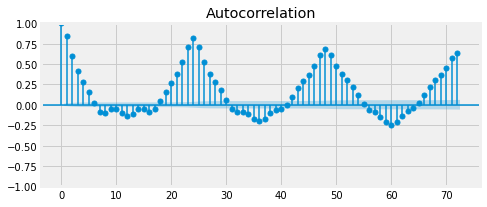

In [20]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos['users'], ax=ax, lags=72)
plt.show()

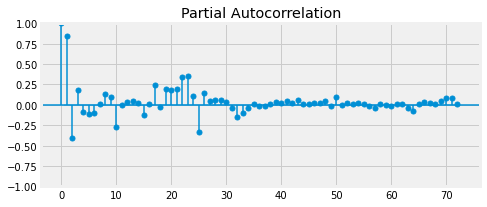

In [21]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos['users'], ax=ax, lags=72, method='ywm')
plt.show()

El estudio de autocorrelación muestra indicios de que, conocer el número de usuarios en las horas previas, así como los días anteriores a la misma hora, puede resultar util para predecir el número de usuarios.

## XGBoost
<br>

[**XGBoost**](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), acrónimo de *Extreme Gradient Boosting* es una implementación muy eficiente del algoritmo de *stochastic gradient boosting* que se ha convertido en un referente dentro del ámbito de *machine learning*. Además de su propia API, la librería XGBoost incluye la clase *XGBRegressor* que sigue la API de scikit learn y, por lo tanto, es compatible con **skforecast**.

Como primera aproximación se utiliza un modelo autorregresivo que utiliza como predictores valores pasados (lags) de la propia variable respuesta. Dada la elevada cantidad de hiperparámetros que tienen los modelos de *gradient boosting*, se emplea una estrategia de [gridsearch](https://joaquinamatrodrigo.github.io/skforecast/0.4.1/guides/tuning-forecaster.html) combinada con [backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.4.1/guides/backtesting.html) para identificar la configuración con la que se obtienen mejores predicciones.

In [22]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'objective': 'reg:squarederror', 'base_score': None

### Ajuste de hiperparámetros (*tuning*)
<br>

Es importante que, en la búsqueda de hiperparámetros, no se utilicen los datos de test, de lo contrario podrían aparecer problemas de sobreajuste del modelo. Con este objetivo, se realiza una búsqueda en la que, con cada combinación de hiperparámetros y lags:

1) Se entrena el modelo con los datos de entrenamiento.

2) Se evalúa el modelo con los datos de validación mediante *backtesting* sin reentrenamiento.

3) Se identifica la combinación de hiperparámetros y lags con los que se consigue menor error.

4) Se entrena el modelo con la mejor combinación encontrada, esta vez con todos los datos de entrenamiento y validación.


In [23]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos.loc[:fin_validacion, 'users'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 48


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [04:24<00:00, 66.04s/it]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 13132.573900322006



In [24]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",13132.573900,0.10,5.0,500.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14407.853484,0.10,5.0,100.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14677.093172,0.10,5.0,500.0
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",14959.220470,0.10,10.0,100.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15135.992088,0.10,3.0,500.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15198.601754,0.10,3.0,500.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",15527.191495,0.10,10.0,500.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",15922.192863,0.10,10.0,500.0
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",16312.056663,0.01,5.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",16431.762039,0.10,10.0,100.0


### Backtesting periodo de test
<br>

Una vez identificada la mejor combinación de hiperparámetros **utilizando los datos de validación** se evalúa la capacidad predictiva del modelo con el conjunto de test. Para poder simular el proceso de predicción cada 36 horas, se recurre a la función `backtesting_forecaster`. Para mejor conocer las posibilidades que ofrece esta función, es conveniente echar un vistazo a su documentación:


```
    Backtesting of forecaster model.
    If `refit` is False, the model is trained only once using the `initial_train_size`
    first observations. If `refit` is True, the model is trained in each iteration
    increasing the training set. A copy of the original forecaster is created so 
    it is not modified during the process.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterAutoregCustom, ForecasterAutoregMultiOutput
        Forecaster model.
        
    y : pandas Series
        Training time series values. 
    
    initial_train_size: int, default `None`
        Number of samples in the initial train split. If `None` and `forecaster` is already 
        trained, no initial train is done and all data is used to evaluate the model. However, 
        the first `len(forecaster.last_window)` observations are needed to create the 
        initial predictors, so no predictions are calculated for them.
        `None` is only allowed when `refit` is False.
        
    steps : int
        Number of steps to predict.
        
    metric : {'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog :panda Series, pandas DataFrame, default `None`
        Exogenous variable/s included as predictor/s. Must have the same
        number of observations as `y` and should be aligned so that y[i] is
        regressed on exog[i].
        
    refit: bool, default False
        Whether to re-fit the forecaster in each iteration.
        
    interval: list, default `None`
        Confidence of the prediction interval estimated. Sequence of percentiles
        to compute, which must be between 0 and 100 inclusive. If `None`, no
        intervals are estimated. Only available for forecaster of type ForecasterAutoreg
        and ForecasterAutoregCustom.
            
    n_boot: int, default `500`
        Number of bootstrapping iterations used to estimate prediction
        intervals.
        
    in_sample_residuals: bool, default `True`
        If `True`, residuals from the training data are used as proxy of
        prediction error to create prediction intervals.  If `False`, out_sample_residuals
        are used if they are already stored inside the forecaster.
        
    set_out_sample_residuals: 'deprecated'
        Deprecated since version 0.4.2, will be removed on version 0.5.0.
                  
    verbose : bool, default `False`
        Print number of folds and index of training and validation sets used for backtesting.
        
    Returns 
    -------
    metric_value: numpy ndarray shape (1,)
        Value of the metric.
        
    backtest_predictions: pandas DataFrame
        Value of predictions and their estimated interval if `interval` is not `None`.
            column pred = predictions.
            column lower_bound = lower bound of the interval.
            column upper_bound = upper bound interval of the interval.
```

In [25]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")

Error de backtest: [12170.95011873]


In [26]:
# Predicciones test
# ==============================================================================
predicciones

,pred
2012-09-01 00:00:00,126.663780
2012-09-01 01:00:00,55.589142
2012-09-01 02:00:00,31.353735
2012-09-01 03:00:00,9.031096
2012-09-01 04:00:00,5.923358
...,...
2012-12-31 19:00:00,149.999588
2012-12-31 20:00:00,98.918289
2012-12-31 21:00:00,77.868027
2012-12-31 22:00:00,54.168060


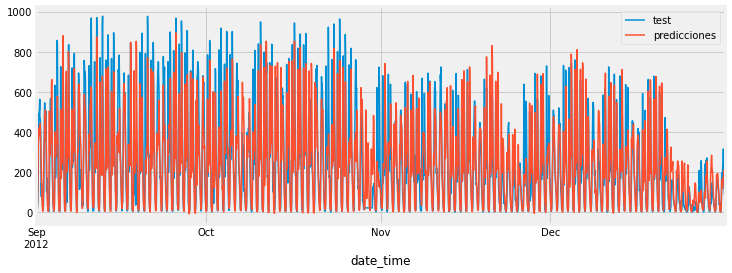

In [27]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['users'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [28]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['users'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de usuarios',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Incluir variables exógenas
<br> 

Además de utilizar predictores autorregresivos generados a partir del pasado de la propia variable respuesta, es posible añadir otras variables exógenas. En este caso, se dispone de información sobre el calendario (mes, día de la semana, hora, festivos,...) así como variables meteorológicas (viento, temperatura, humedad...).

*Nota: el uso de variables meteorológicas debe hacerse con precaución. Cuando el modelo se ponga en producción, no se conocerá a ciencia cierta qué condiciones habrá en el futuro, sino que se dispondrá de predicciones generadas por los servicios meteorológicos. Dado que se trata de predicciones, contendrán errores que se estarán introduciendo en el modelo de forecasting. Como consecuencia, es muy probable que las predicciones del modelo empeoren. Una forma de anticiparse a este problema y conocer el rendimiento esperado del modelo (que no evitarlo) es utilizar en el entrenamiento las predicciones meteorológicas que había en ese momento, no las condiciones registradas.*

Las variables *month*, *weekday*, aunque codificadas como números, son de tipo categórico, por lo que conviene cambiar el tipo con el que están almacenadas. Las variables *holiday* y *workingday* también son categóricas pero, al tener solo dos niveles y estar codificados como (0-1), no es necesario modificarlas.

In [29]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
datos['weather'] = datos['weather'].astype('category')
datos['month']   = datos['month'].astype('category')
datos['weekday'] = datos['weekday'].astype('category')

Las variables con un patrón cíclico, como por ejemplo la hora, pueden tratarse de diferentes formas, cada una con ventajas y desventajas:

+ Si se tratan directamente como variables numéricas, se evita tener que aplicarles una transformación de tipo *One Hot Encoding*, lo que generaría en 24 nuevas variables (hora_1, hora_2 ...). La desventaja es que se impone un orden lineal no cíclico, haciendo por ejemplo, que la hora 23 de un día y las 00 del siguiente estén muy distantes cuando realmente solo hay una hora de diferencia entre ellas.

+ Si se tratan como variables categóricas, no se impone un orden lineal, aunque también se pierde la naturaleza cíclica.

Una estrategia muy útil cuando se trabaja con variables de tipo cíclico, es transformarlas utilizando el seno y coseno del círculo que describen. De esta forma, solo se generan dos variables nuevas y se mantiene su orden natural.

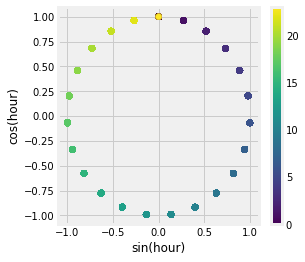

In [30]:
# Transformación seno-coseno de la variable hora
# ==============================================================================
datos['hour_sin'] = np.sin(datos['hour'] / 23 * 2 * np.pi)
datos['hour_cos'] = np.cos(datos['hour'] / 23 * 2 * np.pi)

# Representación de la transformación seno-coseno de la variable hora
# ==============================================================================
fig, ax = plt.subplots(figsize=(4, 4))
sp = ax.scatter(datos["hour_sin"], datos["hour_cos"], c=datos["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

datos = datos.drop(columns='hour')

Existen varias formas para incorporar variables categóricas en un modelo *XGBoost*. En este ejemplo, dado que las variables categóricas no tienen muchos niveles, se recurre a la estrategia de [*One Hot Encoding*](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html#Binarizaci%C3%B3n-de-las-variables-cualitativas). La versión 0.4 de la librería skforecast no permite incluir `ColumnTransformer` en el *pipeline* utilizado como regresor, por lo que, si las transformaciones de preprocesado solo aplican a algunas columnas concretas, se tienen que realizar sobre el conjunto de datos antes de entrenar el modelo.

In [31]:
# One hot encoding
# ==============================================================================
datos = pd.get_dummies(datos, columns=['weather', 'month', 'weekday'])
datos.head(3)

,holiday,workingday,temp,atemp,hum,windspeed,users,hour_sin,hour_cos,weather_clear,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,9.84,14.395,81.0,0.0,16.0,0.000000,1.000000,1,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 01:00:00,0.0,0.0,9.02,13.635,80.0,0.0,40.0,0.269797,0.962917,1,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 02:00:00,0.0,0.0,9.02,13.635,80.0,0.0,32.0,0.519584,0.854419,1,...,0,0,0,0,0,0,0,0,1,0


In [32]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding.
variables_exogenas = [column for column in datos.columns
                      if column.startswith(('weather', 'month', 'hour', 'weekday'))]
variables_exogenas.extend(['holiday', 'temp', 'atemp', 'hum', 'windspeed'])
print(variables_exogenas)

['hour_sin', 'hour_cos', 'weather_clear', 'weather_mist', 'weather_rain', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'holiday', 'temp', 'atemp', 'hum', 'windspeed']


In [33]:
# Como los datos han sido modificados, se repite el reparto en train, val y test.
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

In [34]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

In [35]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'users'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:38<00:00, 79.38s/it]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 8912.662678308314



In [36]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: [6388.0224724]


Al incluir las variables exógenas como predictores, se consigue reducir el error de predicción aproximadamente a la mitad.

### Importancia predictores

In [37]:
# Importancia predictores
# ==============================================================================
importancia = forecaster.get_feature_importance()
importancia

,feature,importance
0,lag_1,0.248002
1,lag_2,0.005347
2,lag_3,0.003233
3,lag_4,0.005951
4,lag_5,0.002000
...,...,...
96,holiday,0.001043
97,temp,0.001690
98,atemp,0.002490
99,hum,0.001414


## LightGBM y CatBoost
<br>

Tras el éxito de XGBoost como algoritmo de machine learning, se han desarrollado nuevas implementaciones que también consiguen excelentes resultados, dos de ellas son:

+ [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/): desarrollada por Microsoft.

+ [**CatBoost**](https://catboost.ai/): desarrollada por Yandex.

A continuación se muestra cómo utilizarlas dentro de skforecast.

### LightGBM

In [38]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-01-01 20:10:24 
Last fit date: None 
Skforecast version: 0.4.2 

In [39]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'users'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:44<00:00, 22.16s/it]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 8814.536841168821



In [40]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",8814.536841,0.10,10.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8838.983329,0.10,3.0,500.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9033.934124,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9034.016763,0.10,5.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9460.577093,0.10,5.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9699.111031,0.10,10.0,100.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",10234.834660,0.10,3.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",10844.341010,0.10,5.0,100.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11092.127609,0.10,10.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",11938.993487,0.01,10.0,500.0


In [41]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: [5932.9168588]


In [42]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,785
1,lag_2,300
2,lag_3,208
3,lag_4,300
4,lag_5,186
...,...,...
96,holiday,22
97,temp,195
98,atemp,201
99,hum,284


### CatBoost
<br>

In [43]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x7f912c6cb150> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-01-01 20:11:14 
Last fit date: None 
Skforecast version: 0.4.2 

In [44]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'users'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [04:50<00:00, 145.01s/it]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 6779.454203090569



In [45]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6779.454203,0.1,5.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8013.664614,0.1,3.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",8107.921257,0.1,5.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9269.532296,0.1,10.0,500.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9613.039031,0.1,10.0,500.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",9696.337248,0.1,3.0,500.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10396.453214,0.1,10.0,100.0
20,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",10670.330703,0.1,5.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",11129.672504,0.1,5.0,100.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11467.609975,0.1,10.0,100.0


In [46]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: [5801.14436506]


## Conclusión
<br>

+ Como se ha mostrado en este documento, la incorporación de variables exógenas como predictores puede mejorar en gran medida la capacidad predictiva.

+ Utilizar modelos de machine learning en problemas de *forecasting* es muy sencillo gracias a las funcionalidades ofrecidas por **skforecast**.

+ El modelo de *gradient boosting* generado mediante **CatBoost** obtiene, para este caso, resultados ligeramente superiores a las otras dos librerías.
<br><br>

## Información de sesión

In [47]:
import session_info
session_info.show(html=False)

-----
catboost            1.0.3
ipykernel           6.4.1
joblib              1.0.1
lightgbm            3.3.1
matplotlib          3.4.3
numpy               1.19.5
pandas              1.3.0
plotly              5.4.0
session_info        1.0.0
skforecast          0.4.2
sklearn             1.0.1
statsmodels         0.13.0
xgboost             1.3.3
-----
IPython             7.27.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.1.11
notebook            6.3.0
-----
Python 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
Linux-5.11.0-43-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2022-01-01 20:16


## Bibliografía
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [libro](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [libro](https://openforecast.org/adam/)

Python for Finance: Mastering Data-Driven Finance [libro](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

[**skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html)

In [48]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    #font-size: 16px;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    #font-size: 1em;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y Catboost by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.